In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy
import corner
from IPython.display import display, Math
import pandas as pd
from decimal import Decimal, getcontext
import mpmath as mp


In [2]:
# define useful functions - for now Omg_k is zero

# Equation 2.14
def Omega_Lambda(cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    
    return 1 - Omega_m - Omega_r - Omega_k + alpha_tilde * (1 - C_t**2 + Omega_k**2 - 2*Omega_k)

# Equation 2.13
# x = ln(a)
def X(x, cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    return 1 + 4 * alpha_tilde * (Omega_m * mp.exp(-3*x) + (Omega_r + alpha_tilde*C_t**2) * mp.exp(-4*x) + Omega_lambda)

# Equation 2.12
# x = ln(a)
def E(x , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    E_L = Omega_m * mp.exp(-3*x) + (Omega_r + alpha_tilde*C_t**2) * mp.exp(-4*x) + Omega_lambda
    
    if alpha_tilde == 0:
        ans = mp.sqrt(E_L + Omega_k * mp.exp(-2*x))
    
    else:
        ans = mp.sqrt((mp.sqrt(X(x , cosmo)) - 1 + (2 * alpha_tilde * Omega_k * mp.exp(-2*x)))/(2 * alpha_tilde))
    
    return ans

# x = ln(a)
def unitless_time(x_val ,cosmo):
    t = mp.quad(lambda x: 1/(E(x,cosmo)), [float('-inf') , x_val])
    return t

# x = ln(a)
def x_planck_time(t , cosmo):
    Omg_c , Omg_b , Omg_k , Omg_r, alpha_t, C_t = cosmo
    x = mp.log10((Omg_r/alpha_t)**0.25 * t)
    return x

# particle horizon
def r_hor_fracH0c(x_val,cosmo, x_min):
    Omg_c , Omg_b , Omg_k , Omg_r, alpha_t, C_t = cosmo
    Omg_m = Omg_b + Omg_c 
    
    return mp.quad(lambda x: 1/(mp.exp(x)*E(x, cosmo)), [x_min, x_val])


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


In [3]:
# find Planck scale factor from planck time
Omg_rad = (1 + (7/8) * (4/11)**(4/3)*3.046)*9.227e-5

mp.mp.dps = 100

cosmo1 = [0.264 , 0.0493 , 0 , Omg_rad, 1e-15, 0]
cosmo2 = [0.264 , 0.0493 , 0 , Omg_rad, 1e-36, 0]
cosmo3 = [0.264 , 0.0493 , 0 , Omg_rad, 1e-43, 0]
cosmoLCDM = [0.264 , 0.0493 , 0 , Omg_rad, 0, 0]                      #  Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t

x_tofindtime = np.linspace(-70,-50, int(5e2))
t_planck = 5.391247e-44 #s
t_planck = t_planck * 67/(3.086e22) # unitless
print(t_planck)

x_planck1 = x_planck_time(t_planck , cosmo1)
x_planck2 = x_planck_time(t_planck , cosmo2)
x_planck3 = x_planck_time(t_planck , cosmo3)
print(x_planck1)
print(x_planck2)
print(x_planck3)


1.1704910855476345e-64
-61.13328150080199007504143591812569057180172949674669425277153404793423808804266077772028999805786493
-55.8832815008019900446280978968486397845486398328708214600636932019338100288274877837644107308584398
-54.1332815008019900560014204977408185816776756313548581637738180038510108423470737972783562052362734


In [52]:
Omg_rad = (1 + (7/8) * (4/11)**(4/3)*3.046)*9.227e-5

cosmoLarge = [0.264 , 0.0493 , 0 , Omg_rad, 1e-43, 0]

mp.mp.dps = 50

xmin = -1e11

print(r_hor_fracH0c(mp.log10(1/1101),cosmoLarge, xmin)/(r_hor_fracH0c(0,cosmoLarge, xmin)-r_hor_fracH0c(mp.log10(1/1101),cosmoLarge, xmin)))


6.7436038593987008908736908984531103568540839434272


In [72]:

xmin = -np.logspace(1.733,11, 100)

theta = np.zeros(len(xmin))
for i in range(len(xmin)):
    theta[i] = r_hor_fracH0c(mp.log10(1/1101),cosmoLarge, xmin[i])/(r_hor_fracH0c(0,cosmoLarge, xmin[i])-r_hor_fracH0c(mp.log10(1/1101),cosmoLarge, xmin[i]))


4.326725599681492510598502362942579073684499490632576584065784522737572417850856619865876126060541249e-18338341991
5.211800211917318558482180079270877980553333038154490630194122352554362471887610809082565049455597485e-34
7.522312730695686572857316693099370452377315887575534833451645763180877208926210241006737460638451073e-43429448201


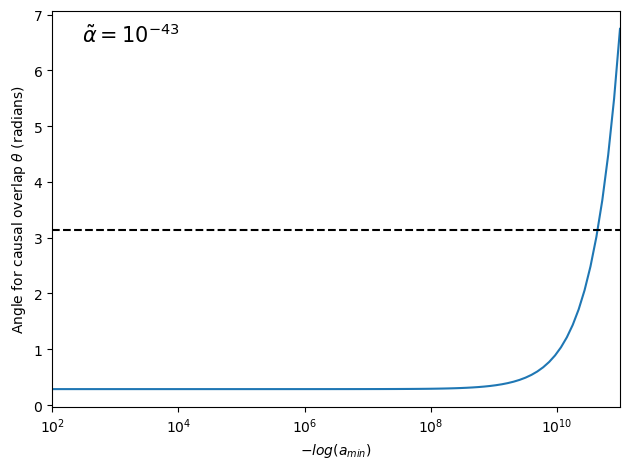

In [127]:
plt.plot(-xmin,theta)
plt.plot([1e2,1e11],[3.14,3.14], "k--")
plt.xlim(1e2,1e11)
plt.xscale("log")
plt.xlabel(r"$-log(a_{min})$")
plt.ylabel(r"Angle for causal overlap $\theta$ (radians)")
plt.text(300, 6.5, r"$\tilde{\alpha} = 10^{-43}$", fontsize=15)
print(unitless_time(xmin[find_nearest(theta,3.14)],cosmoLarge)/t_planck)
print(unitless_time(xmin[0] ,cosmoLarge))
print(unitless_time(xmin[-1] ,cosmoLarge))
#plt.savefig("Planck_cutoff_horizon")

In [111]:
# find Planck scale factor from planck time
Omg_rad = (1 + (7/8) * (4/11)**(4/3)*3.046)*9.227e-5

mp.mp.dps = 100

alpha_C = np.logspace(-43,-7, 50)
cosmoLCDM = [0.264 , 0.0493 , 0 , Omg_rad, 0, 0]                      #  Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t

x_min = -np.logspace(1.733,9, 10)

theta_hor = np.zeros((len(x_min),len(alpha_C)))
theta_hor_p = np.zeros(len(alpha_C))
for i in range(len(alpha_C)):
    cosmo_i = [0.264 , 0.0493 , 0 , Omg_rad, alpha_C[i], 0]
    for k in range(len(x_min)):    
        theta_hor[k][i] = r_hor_fracH0c(mp.log10(1/1101),cosmo_i, x_min[k])/(r_hor_fracH0c(0,cosmo_i, x_min[k])-r_hor_fracH0c(mp.log10(1/1101),cosmo_i, x_min[k]))
    theta_hor_p[i] = r_hor_fracH0c(mp.log10(1/1101),cosmo_i, x_planck_time(t_planck , cosmo_i))/(r_hor_fracH0c(0,cosmo_i, x_planck_time(t_planck , cosmo_i))-r_hor_fracH0c(mp.log10(1/1101),cosmo_i, x_planck_time(t_planck , cosmo_i)))

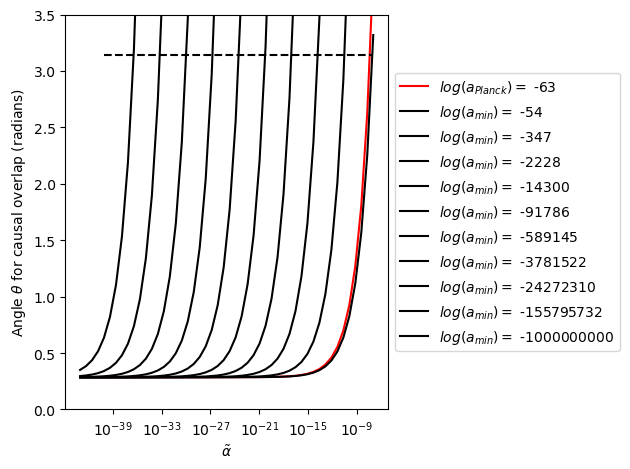

In [119]:
#print(theta_hor)
plt.plot(alpha_C,theta_hor_p, color="r", label =r"$log(a_{Planck}) =$ %.0f" %(x_planck_time(t_planck , cosmo_i)))
for i in range(len(theta_hor)):
    plt.plot(alpha_C,theta_hor[i], "k", label =r"$log(a_{min}) =$ %.0f" %(x_min[i]))
plt.xscale("log")
plt.plot([1e-40,1e-7],[3.14,3.14], "k--")
#print(alpha_C[find_nearest(theta_hor_p,1)])
plt.ylim(0,3.5)
plt.ylabel(r"Angle $\theta$ for causal overlap (radians)")
plt.xlabel(r"$\tilde{\alpha}$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.rcParams["figure.autolayout"] = True
#plt.savefig("Planck_cutoff_horizon2")

In [4]:
# find comoving distance today/CMB
print(r_hor_fracH0c(0,cosmoLCDM, -3.0418))

2.463721545176399197192347955928835264327004462758220185324250543420058039805673799407482426011575363
